In [1]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 93% 56.0M/60.3M [00:00<00:00, 90.6MB/s]
100% 60.3M/60.3M [00:00<00:00, 74.6MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import cv2
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten


<Axes: >

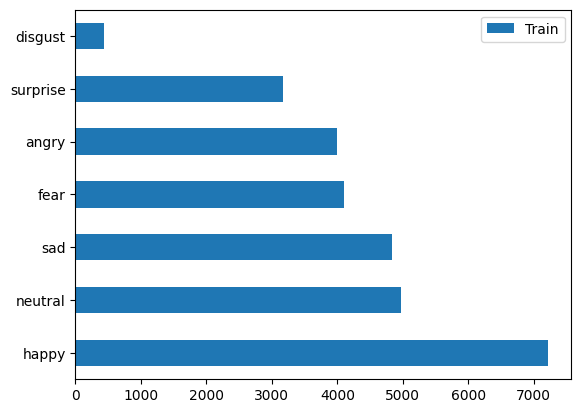

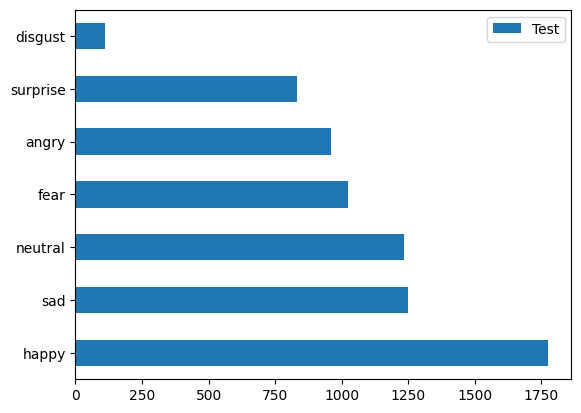

In [4]:
# Directory paths
train_dir = "/content/train/"
test_dir = "/content/test/"

# Function to count classes
def Classes_Count(path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df

# Counting classes
Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

pd.concat([Train_Count, Test_Count], axis=1)
Train_Count.plot(kind='barh')
Test_Count.plot(kind='barh')


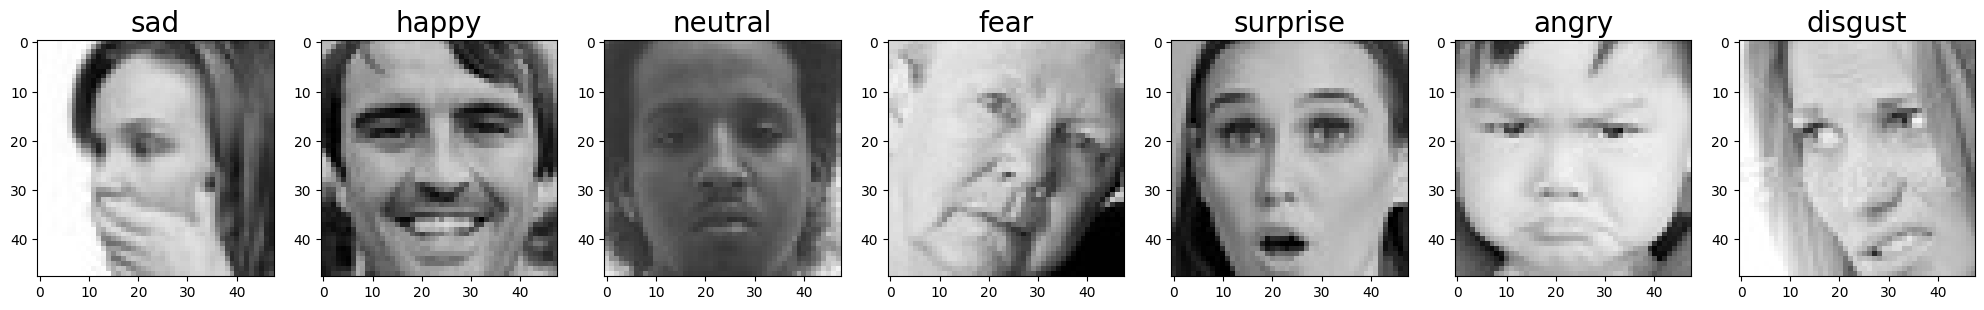

In [5]:
# Displaying sample images
plt.style.use('default')
plt.figure(figsize=(25, 8))
image_count = 1
BASE_URL = '/content/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize=20)


In [6]:
# Image pre-processing and augmentation
img_shape = 75
batch_size = 64
train_data_path = '/content/train/'
test_data_path = '/content/test/'

train_preprocessor = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_preprocessor = ImageDataGenerator(rescale=1 / 255.)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# Freeze all layers except the last 50 in InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_shape, img_shape, 3))
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Define InceptionV3-based model
def Create_InceptionV3_Model():
    model = Sequential([
        base_model,
        Dropout(0.25),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

InceptionV3_Model = Create_InceptionV3_Model()
InceptionV3_Model.summary()

# Compile the model
InceptionV3_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_path = "InceptionV3_Model_Checkpoint"
Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

Reducing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00005, verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

# Train the model
InceptionV3_history = InceptionV3_Model.fit(
    train_data,
    validation_data=test_data,
    epochs=30,
    batch_size=batch_size,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 1, 1, 2048)        0         
                                                                 
 batch_normalization_94 (Ba  (None, 1, 1, 2048)        8192      
 tchNormalization)                                               
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 batch_normalization_95 (Ba  (None, 64)                25

KeyboardInterrupt: 

In [ ]:
# Evaluating the model
InceptionV3_Score = InceptionV3_Model.evaluate(test_data)
print("Test Loss: {:.5f}".format(InceptionV3_Score[0]))
print("Test Accuracy: {:.2f}%".format(InceptionV3_Score[1] * 100))

# Plotting training history
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

plot_curves(InceptionV3_history)


In [ ]:
# Confusion matrix
CNN_Predictions = InceptionV3_Model.predict(test_data)
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_data.labels, CNN_Predictions)
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('InceptionV3 Confusion Matrix', fontsize=20, fontweight='bold')
ax.set_xticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_yticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_xticklabels(Emotion_Classes, rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(Emotion_Classes, rotation=0, fontsize=12, fontweight='bold')
plt.show()


In [ ]:
# Displaying random test images with predictions
test_preprocessor = ImageDataGenerator(rescale=1 / 255.)

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size
)

Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(InceptionV3_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))

    ax.imshow(Random_Img)
    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()